<a href="https://colab.research.google.com/github/shivtejshete/Computer-Vision/blob/dev/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import os

In [2]:
print(tf.__version__)
print(keras.__version__)


2.3.0
2.4.3


In [3]:
#building the datapipeline 
url = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

zip_path = tf.keras.utils.get_file('cats_dogs.zip', origin=url, extract=True)

path = os.path.join(os.path.dirname(zip_path), 'cats_and_dogs_filtered' )

train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'validation')

batch_size = 32
image_size = (160, 160)


68608000/68606236 [==============================] - 0s 0us/step


In [4]:
train_dataset = keras.preprocessing.image_dataset_from_directory(train_dir, batch_size=batch_size, image_size=image_size, shuffle=True, color_mode='rgb')

Found 2000 files belonging to 2 classes.


In [5]:
class_indices = train_dataset.class_names

In [6]:
validation_dataset = keras.preprocessing.image_dataset_from_directory(validation_dir, batch_size = batch_size, image_size = image_size, shuffle=True, color_mode='rgb')

Found 1000 files belonging to 2 classes.


0
1
1
1


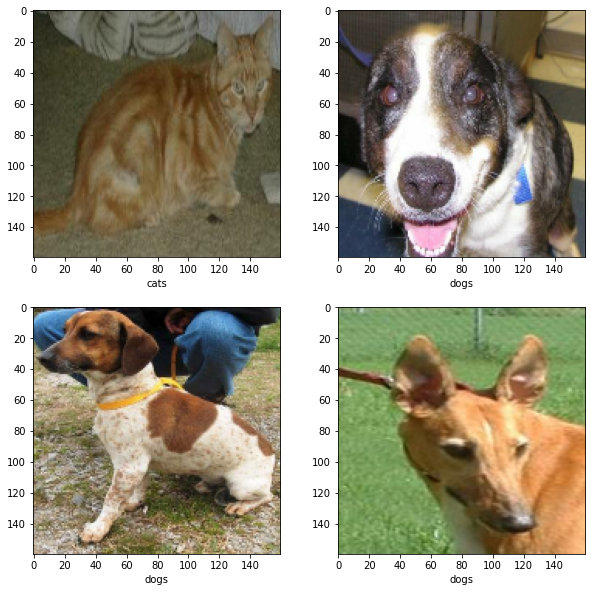

In [7]:
#plotting sample data from first batch of training dataset
plt.figure(figsize = (10,10))
for image, label in train_dataset.take(1):
  for i in range(4):
      ax= plt.subplot(2,2,i+1)
      plt.imshow(np.array(image[i], dtype= 'int'))
      plt.xlabel(class_indices[label[i]])
      tf.print(label[i])


In [8]:
#checking number of batches into validation dataset
value_batches = tf.data.experimental.cardinality(validation_dataset)

In [9]:
#creation of test data subset
test_dataset=validation_dataset.take(value_batches//5)
validation_dataset= validation_dataset.skip(value_batches//5)

In [10]:
#checking number of batches into training dataset
tf.print(tf.data.experimental.cardinality(train_dataset))

63


In [11]:
#he number of elements to prefetch should be equal to (or possibly greater than) the number of batches consumed by a single training step.
#  You could either manually tune this value, or set it 
# to tf.data.experimental.AUTOTUNE which will prompt the tf.data runtime to tune the value dynamically at runtime.
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [12]:

#Prefetch the data for reducing latency and increase throughput 
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [13]:
#Augmentation layer, its no required if we use a generator from keras
augment = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomRotation(0.2, seed=11),
    keras.layers.experimental.preprocessing.RandomFlip( seed=1),
    keras.layers.experimental.preprocessing.RandomContrast(factor = 0.1)
]
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

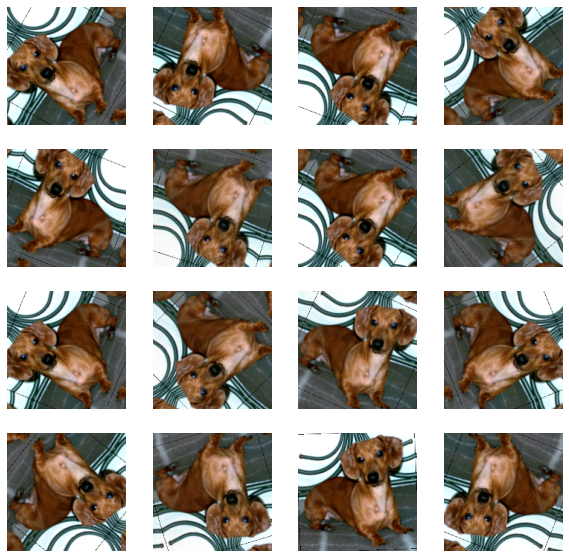

In [14]:
#visualize how data augmentation happens
for image, label in train_dataset.take(1):
  plt.figure(figsize=(10,10))
  image2 = image[1]
  for i in range(16):
    ax = plt.subplot(4,4,i+1)
    augmented = augment(np.expand_dims(image2, 0))
    plt.imshow(np.reshape(np.array(augmented, dtype = 'int'),(160,160,3)))
    plt.axis(False )

In [15]:
#MobileNetV2 has some preprocessing and we can access that specific layer directly to process our data in same fashion
#This is just a rescale of data by 255.0
preprocess_data_for_imagenetv2 = tf.keras.applications.mobilenet_v2.preprocess_input




In [16]:
# Building block of Image netv2 = [Expansion layer, batch Normalization, ReLU] + [Conv+BN+ReLU] + [Projection Layer+ BN] + Residual from begininng 
# The full MobileNet V2 architecture consists of 17 of these building blocks in a row. 
# This is followed by a regular 1×1 convolution, a global average pooling layer, and a classification layer.
image_shape = image_size + (3,)

base_model = keras.applications.MobileNetV2( input_shape= image_shape , include_top=False, weights= 'imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [17]:
#Model takes in 160 with 3 channel image size and converts it into 5 with 1280 channels
# 
base_model.summary()


Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [18]:
#total number of layers in the architecture 
len(base_model.layers)

155

In [19]:
# Seeing if architecture giving expected outcome for input batches 
for image, _ in train_dataset.take(1):
  feature_output = base_model(image)
  print(feature_output.shape)

(32, 5, 5, 1280)


In [20]:
#Freeze all the layers of chosen architecture to avoid retraining
base_model.trainable = False

In [21]:
#Checking the effect of setting trainable to false
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [28]:
# Adding a top layer of classifier to identify dogs and cats  

#Averaging the values of features per image into 1280 element vector, we can use flatten as well
average_pool = keras.layers.GlobalAveragePooling2D( )

#Checking the average pooling on a single image
for image, _ in train_dataset.take(1):
  features= base_model(np.expand_dims(image[0], 0))
  print('Model output shape :',features.shape)
  averaged = average_pool(features)
  print('Shape After average pooling layer :',averaged.shape)

Model output shape : (1, 5, 5, 1280)
Shape After average pooling layer : (1, 1280)


In [29]:
prediction_layer = keras.layers.Dense( units =1 )

In [32]:
#Checking prediction on a single image average pool
prediction_layer(averaged) 

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.3377054]], dtype=float32)>

In [50]:
#groups layers into an object with training and inference features

input = keras.layers.Input( shape = image_shape )
x= augment(input)
x= preprocess_data_for_imagenetv2(x)
x= base_model( x,training = False)
x= average_pool(x)

x = keras.layers.Dropout( 0.2 , seed = 111)(x)

output = prediction_layer(x)

model = keras.Model( inputs = input, outputs = output )


In [51]:
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv_3 (Tenso [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_3 (TensorFlo [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1280)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1280)             

In [52]:
model.trainable_variables

[<tf.Variable 'dense/kernel:0' shape=(1280, 1) dtype=float32, numpy=
 array([[0.05168134],
        [0.02326864],
        [0.03537984],
        ...,
        [0.00834427],
        [0.04076768],
        [0.01462298]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

In [53]:
learning_rate = 0.001
model.compile( optimizer = tf.keras.optimizers.Adam(learning_rate= learning_rate), 
              loss = tf.keras.losses.BinaryCrossentropy( from_logits= True),
              metrics = ['accuracy'])

In [54]:
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv_3 (Tenso [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_3 (TensorFlo [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1280)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1280)             

In [56]:

#Checking accuracy of starting
initial_epoch = 8

loss1, accuracy1 = model.evaluate(validation_dataset)


26/26 [==============================] - 15s 558ms/step - loss: 1.0377 - accuracy: 0.2847


In [59]:
initial_epoch = 8

In [60]:
history = model.fit(train_dataset,
                    epochs=initial_epoch,
                    validation_data=validation_dataset)

Epoch 1/8
63/63 [==============================] - 59s 939ms/step - loss: 0.5001 - accuracy: 0.7250 - val_loss: 0.1503 - val_accuracy: 0.9394
Epoch 2/8
63/63 [==============================] - 60s 949ms/step - loss: 0.2870 - accuracy: 0.8745 - val_loss: 0.1058 - val_accuracy: 0.9678
Epoch 3/8
63/63 [==============================] - 62s 981ms/step - loss: 0.2477 - accuracy: 0.8890 - val_loss: 0.0975 - val_accuracy: 0.9678
Epoch 4/8
63/63 [==============================] - 59s 944ms/step - loss: 0.2344 - accuracy: 0.8960 - val_loss: 0.0947 - val_accuracy: 0.9641
Epoch 5/8
63/63 [==============================] - 60s 945ms/step - loss: 0.2252 - accuracy: 0.8995 - val_loss: 0.0776 - val_accuracy: 0.9752
Epoch 6/8
63/63 [==============================] - 61s 962ms/step - loss: 0.1971 - accuracy: 0.9160 - val_loss: 0.0800 - val_accuracy: 0.9740
Epoch 7/8
63/63 [==============================] - 60s 947ms/step - loss: 0.1979 - accuracy: 0.9145 - val_loss: 0.0793 - val_accuracy: 0.9703
Epoch 

In [65]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

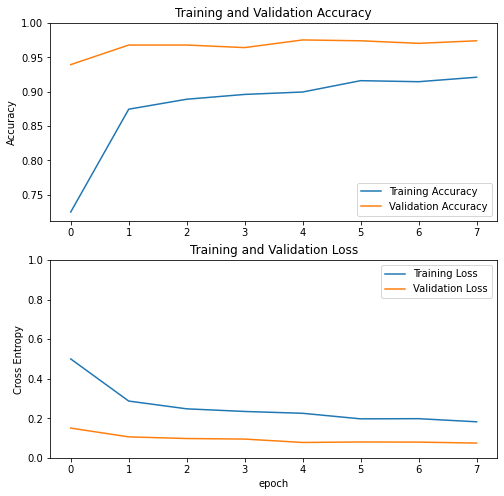

In [66]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()